In [24]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import chardet
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adam 

[nltk_data] Downloading package punkt to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aishwarya
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
with open('../data/nlp_vader_textblob_classified_data.csv', 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
    
tweetData = pd.read_csv('../data/nlp_vader_textblob_classified_data.csv', encoding = enc['encoding'], index_col=False)
tweetData

,username,verified,followersCount,content,label,date,country,replyCount,retweetCount,likeCount,...,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,final_class
0,HuyThanhNguyen5,False,0,@unitedstandmufc @markgoldbridge get ole again...,-1.0,2022-08-31 15:12:54,India,0,0,0,...,0.046,0.819,0.134,0.7133,g e t o l e a g a i n t o t e l l ...,-1,0.600000,0.290000,1,-1
1,guaslackjack,False,125,best goal: bruno top assists: pogba ??: cristi...,1.0,2021-09-11 15:56:21,India,0,0,0,...,0.000,0.561,0.439,0.8225,b e s t g o a l : b r u n o t o p a s ...,1,0.400000,0.533333,1,1
2,gerryrb,False,935,@lost_souls_07 @kayinfinite28 @altyred2 @utdpl...,0.0,2022-09-03 14:29:34,Argentina,1,0,1,...,0.000,0.505,0.495,0.9562,i d o n o t k n o w i s t h ...,1,0.783333,0.450000,1,0
3,rickitten_,False,9,players spurs in old trafford #mufc #muntot ht...,0.0,2022-03-12 19:14:18,India,0,0,0,...,0.000,1.000,0.000,0.0000,p l a y e r s s p u r s i n o l d t r ...,0,0.200000,0.100000,1,0
4,saboteurDS,False,278,@tancredipalmeri why on earth would #mufc pay ...,-1.0,2022-08-28 12:07:34,India,0,0,2,...,0.045,0.643,0.312,0.8072,w h y o n e a r t h w o u l d p a ...,-1,0.500000,0.500000,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97393,ChelseaEleven,False,21757,"thank you for everything, Thomas Tuchel #CFC #...",NaN,2022-09-07 09:09:44+00:00,India,0,1,4,...,0.000,0.667,0.333,0.3612,t h a n k y o u f o r e v e r y t h i n ...,1,0.000000,0.000000,0,1
97394,amber_chelsea,False,2195,@Chukwuemekaa10 thanks for the pic Carney ????...,NaN,2022-08-27 13:17:33+00:00,Zimbabwe,0,0,4,...,0.000,0.580,0.420,0.4404,t h a n k s f o r t h e p i c c a r ...,1,0.200000,0.200000,1,1
97395,Dc_Solomon2,False,143,Contacts ongoing between Chelsea and Brighton ...,NaN,2022-09-07 11:25:44+00:00,Zimbabwe,0,0,1,...,0.000,1.000,0.000,0.0000,c o n t a c t s o n g o i n g b e t w e e ...,0,0.400000,0.400000,1,0
97396,Marcus_Bryan_,False,5439,Billy Gilmour left #ChelseaFC to join Brighton...,NaN,2022-09-08 16:43:30+00:00,Argentina,1,2,24,...,0.000,0.805,0.195,0.5574,b i l l y g i l m o u r l e f t t o ...,1,0.035897,0.000000,0,1


In [6]:
labels = tweetData['final_class']
def featureEngineering(tweet):
    # Lower case tweet
    tweetMod = tweet.lower()
    # Replace URLs with a space in the message
    tweetMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweetMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    tweetMod = re.sub('\$[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    tweetMod = re.sub('\@[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace everything not a letter or apostrophe with a space
    tweetMod = re.sub('[^a-zA-Z\']', ' ', tweetMod)
    # Remove single letter words
    tweetMod = ' '.join([w for w in tweetMod.split() if len(w) > 1])

    return tweetMod


# Process for all tweets
tweetData['modTweet'] = [featureEngineering(tweet) for tweet in tweetData['content']]

def lemmatizeTweet(tweet):
    words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return " ".join(lemmatized)

tweetData['lemmatizedText'] = tweetData["modTweet"].apply(lambda x:lemmatizeTweet(x))

In [7]:
# Function to tokenize the tweet
def tokenizeTweet(tweet, option):
  '''
  Tokenize the tweet, different methods - change as per accuracy and score requirements
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return tweet.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', tweet)
  elif option == 3:
    return [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    return []

# Creating a set of unique words in the dataset
wordsSet = set()
for tweet in tweetData['modTweet']:
    listOfWords = tokenizeTweet(tweet, 4)
    wordsSet.update(listOfWords)

In [8]:
#Total number of unique words
print(len(wordsSet))

37320


In [30]:
tokenizer = Tokenizer(num_words=37320, split=' ')
tokenizer.fit_on_texts(tweetData['lemmatizedText'].values)
X = tokenizer.texts_to_sequences(tweetData['lemmatizedText'].values)
X = pad_sequences(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

In [31]:
Y_train = tf.keras.utils.to_categorical(Y_train, 3)
Y_test = tf.keras.utils.to_categorical(Y_test, 3)

In [15]:
embed_dim = 64

model = Sequential()
model.add(Embedding(37320,embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 43, 64)            2388480   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 43, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               204624    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 2,593,695
Trainable params: 2,593,695
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/20
1066/1066 [==============================] - 168s 153ms/step - loss: 0.6144 - accuracy: 0.7528 - val_loss: 0.4354 - val_accuracy: 0.8550
Epoch 2/20
1066/1066 [==============================] - 152s 142ms/step - loss: 0.3958 - accuracy: 0.8687 - val_loss: 0.4156 - val_accuracy: 0.8632
Epoch 3/20
1066/1066 [==============================] - 158s 149ms/step - loss: 0.3491 - accuracy: 0.8862 - val_loss: 0.4242 - val_accuracy: 0.8600
Epoch 4/20
1066/1066 [==============================] - 155s 145ms/step - loss: 0.3193 - accuracy: 0.8960 - val_loss: 0.4226 - val_accuracy: 0.8597
Epoch 5/20
1066/1066 [==============================] - 158s 148ms/step - loss: 0.2943 - accuracy: 0.9048 - val_loss: 0.4328 - val_accuracy: 0.8608
Epoch 6/20
1066/1066 [==============================] - 159s 149ms/step - loss: 0.2727 - accuracy: 0.9126 - val_loss: 0.4479 - val_accuracy: 0.8601
Epoch 7/20
1066/1066 [==============================] - 159s 150ms/step - loss: 0.2505 - accuracy: 0.9192 - val_

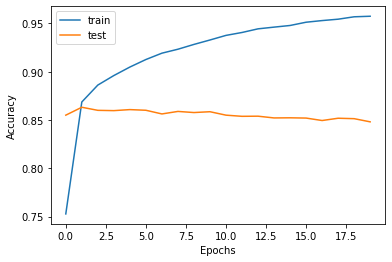

In [17]:
#Plotting the accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')

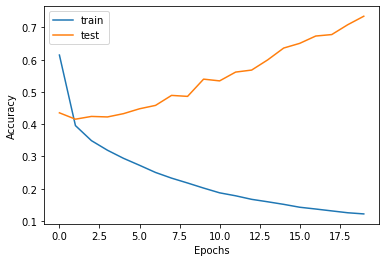

In [18]:
#Plotting the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')

In [28]:
model_dropout = Sequential()
model_dropout.add(Embedding(input_dim = 64,output_dim = 8,input_length = X.shape[1]))
model_dropout.add(Dropout(rate=0.5))
model_dropout.add(Bidirectional(LSTM(units=256, kernel_initializer= 'normal', return_sequences=True, kernel_constraint=maxnorm(4))))
model_dropout.add(Dropout(rate=0.5))
model_dropout.add(Bidirectional(LSTM(units=128, kernel_initializer= 'normal', return_sequences=False)))
model_dropout.add(Dense(3, activation='softmax'))
optimizer = Adam(lr=0.001)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 43, 64)            2388480   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 43, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               204624    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 2,593,695
Trainable params: 2,593,695
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
model_dropout.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
history = model_dropout.fit(X_train, Y_train, epochs = 50, batch_size=512, validation_data=(X_test, Y_test))

Epoch 1/50


InvalidArgumentError:  indices[320,25] = 1016 is not in [0, 64)
	 [[node sequential_7/embedding_7/embedding_lookup (defined at \AISHWA~1\AppData\Local\Temp/ipykernel_2112/4182422220.py:2) ]] [Op:__inference_train_function_91615]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_7/embedding_7/embedding_lookup:
 sequential_7/embedding_7/embedding_lookup/87374 (defined at \Aishwarya Singh\anaconda3\lib\contextlib.py:113)

Function call stack:
train_function
